<a href="https://colab.research.google.com/github/dmosh/deeplearning/blob/main/imageclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#importing the neccessary libraries
import glob
import cv2 as cv
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np
import random
import os
from os import listdir
from os.path import isfile, join
import pathlib
import splitfolders
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.applications.vgg16 import VGG16
from google.colab import drive
#!pip install split-folders

In [3]:
#mount drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
#load and read the images
url = "/content/drive/MyDrive/Colab Notebooks/deeplearning/dataset1/known_images"
image_dir = pathlib.Path(url)


In [5]:
splitfolders.ratio(image_dir, output='imgs', seed=123, ratio=(.8,.2), group_prefix=None)

Copying files: 715 files [00:08, 85.83 files/s] 


In [6]:
normal = [fn for fn in os.listdir(f'{image_dir}/normal') if fn.endswith('.png')]
sick = [fn for fn in os.listdir(f'{image_dir}/sick') if fn.endswith('.png')]

image = [normal, sick]
image_class = []

for i in os.listdir('imgs/train'):
  image_class+=[i]
image_class.sort()

In [7]:
image_count = len(list(image_dir.glob('*/*.png')))
print(f'Total images: {image_count}')
print(f'Total number of classes: {len(image_class)}')
count = 0
images_count = []
for x in image_class:
  print(f'Total {x} images: {len(image[count])}')
  images_count.append(len(image[count]))
  count += 1


Total images: 715
Total number of classes: 2
Total normal images: 364
Total sick images: 351


In [8]:
def load_random_img(dir, label):
  plt.figure(figsize=(10,10))
  i=0
  for label in image_class:
    i+=1
    plt.subplot(1, 5, i)
    file = random.choice(os.listdir(f'{dir}/{label}'))
    image_path = os.path.join(f'{dir}/{label}', file)
    img=cv.imread(image_path)
    plt.title(label)
    plt.imshow(img)
    plt.grid(None)
    plt.axis('off')

image preprocessing

In [9]:
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)

In [10]:
datagen = ImageDataGenerator(rescale=1./255)

In [11]:
train_ds = datagen.flow_from_directory(
    'imgs/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    color_mode="rgb",
    subset = "training",
    class_mode='categorical',
    shuffle=True,
    seed = 42)

val_ds = datagen.flow_from_directory(
    'imgs/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False,
    seed = 42)

test_ds = datagen.flow_from_directory(
    'imgs/test',
    target_size = (img_height, img_width),
    batch_size = 1,
    color_mode="rgb",
    class_mode=None,
    shuffle=False,
    seed=42)



Found 571 images belonging to 2 classes.
Found 144 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [12]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

VGG16 Model

In [13]:
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
vgg16.trainable = False
inputs = tf.keras.Input(input_shape)
x = vgg16(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x)
model_vgg16 = tf.keras.Model(inputs, x)

58900480/58889256 [==============================] - 0s 0us/step


In [14]:
model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_vgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dense_1 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 15,242,050
Trainable params: 527,362
Non-trainable params: 14,714,688
___________________________________________

In [15]:
checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/deeplearning/saved_models/cnn_model.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [16]:
learning1 = model_vgg16.fit(train_ds, epochs = 30, validation_data = val_ds, callbacks=callbacks)

Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.5723 - accuracy: 0.6918
Epoch 1: val_accuracy improved from -inf to 0.63194, saving model to /content/drive/MyDrive/Colab Notebooks/deeplearning/saved_models/cnn_model.hdf5
18/18 [==============================] - 23s 524ms/step - loss: 0.5723 - accuracy: 0.6918 - val_loss: 0.5373 - val_accuracy: 0.6319 - lr: 0.0010
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.4053 - accuracy: 0.8424
Epoch 2: val_accuracy improved from 0.63194 to 0.90278, saving model to /content/drive/MyDrive/Colab Notebooks/deeplearning/saved_models/cnn_model.hdf5
18/18 [==============================] - 4s 241ms/step - loss: 0.4053 - accuracy: 0.8424 - val_loss: 0.3543 - val_accuracy: 0.9028 - lr: 0.0010
Epoch 3/30
18/18 [==============================] - ETA: 0s - loss: 0.2874 - accuracy: 0.9229
Epoch 3: val_accuracy did not improve from 0.90278
18/18 [==============================] - 4s 201ms/step - loss: 0.2874 - accur

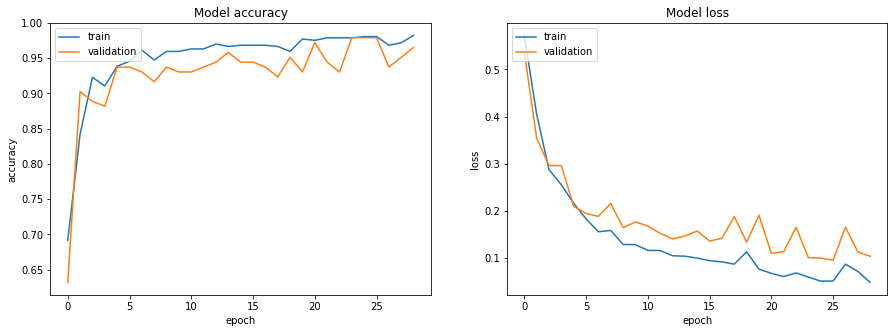

In [17]:
model_vgg16.load_weights('/content/drive/MyDrive/Colab Notebooks/deeplearning/saved_models/cnn_model.hdf5')
plot_train_history(learning1)

In [18]:
score1 = model_vgg16.evaluate(test_ds, verbose=1)
print(f'Model 2 VGG16 Loss: {score1[0]}, Accuracy: {score1[1]*100}')

50/50 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Model 2 VGG16 Loss: 0.0, Accuracy: 0.0


Finetune the model

In [19]:
vgg16.trainable = True
model_vgg16.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
learning2 = model_vgg16.fit(train_ds, epochs = 10, validation_data = val_ds, callbacks=callbacks)

Epoch 1/10
18/18 [==============================] - ETA: 0s - loss: 0.2073 - accuracy: 0.9159
Epoch 1: val_accuracy did not improve from 0.97917
18/18 [==============================] - 21s 817ms/step - loss: 0.2073 - accuracy: 0.9159 - val_loss: 0.1445 - val_accuracy: 0.9444 - lr: 1.0000e-05
Epoch 2/10
18/18 [==============================] - ETA: 0s - loss: 0.0563 - accuracy: 0.9807
Epoch 2: val_accuracy did not improve from 0.97917
18/18 [==============================] - 10s 582ms/step - loss: 0.0563 - accuracy: 0.9807 - val_loss: 0.0923 - val_accuracy: 0.9792 - lr: 1.0000e-05
Epoch 3/10
18/18 [==============================] - ETA: 0s - loss: 0.0216 - accuracy: 0.9982
Epoch 3: val_accuracy did not improve from 0.97917
18/18 [==============================] - 10s 563ms/step - loss: 0.0216 - accuracy: 0.9982 - val_loss: 0.0626 - val_accuracy: 0.9792 - lr: 1.0000e-05
Epoch 4/10
18/18 [==============================] - ETA: 0s - loss: 0.0081 - accuracy: 1.0000
Epoch 4: val_accuracy di

In [21]:
model_vgg16.load_weights('/content/drive/MyDrive/Colab Notebooks/deeplearning/saved_models/cnn_model.hdf5')

In [22]:
score2 = model_vgg16.predict(test_ds, verbose=1)
#print(f'Model 1 Vanilla Loss: {score1[0]}, Accuracy: {score1[1]*100}')
print(f'Model 2 VGG16 Loss: {score1[0]}, Accuracy: {score1[1]*100}')
print(f'Model 2 VGG16 Fine-tuned Loss: {score2[0]}, Accuracy: {score2[1]*100}')

50/50 [==============================] - 1s 11ms/step
Model 2 VGG16 Loss: 0.0, Accuracy: 0.0
Model 2 VGG16 Fine-tuned Loss: [0.99010974 0.00989027], Accuracy: [1.7696326e-03 9.9998238e+01]


In [23]:
Y_pred = model_vgg16.predict(test_ds)

In [24]:
predicted_class_indices=np.argmax(Y_pred,axis=1)

In [25]:
labels = (train_ds.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [32]:
filenames=test_ds.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("/content/drive/MyDrive/Colab Notebooks/deeplearning/Unkown_Image_pred.csv",index=False, header=["Epuret Moses Obuya", "2021/HD05/2291"])

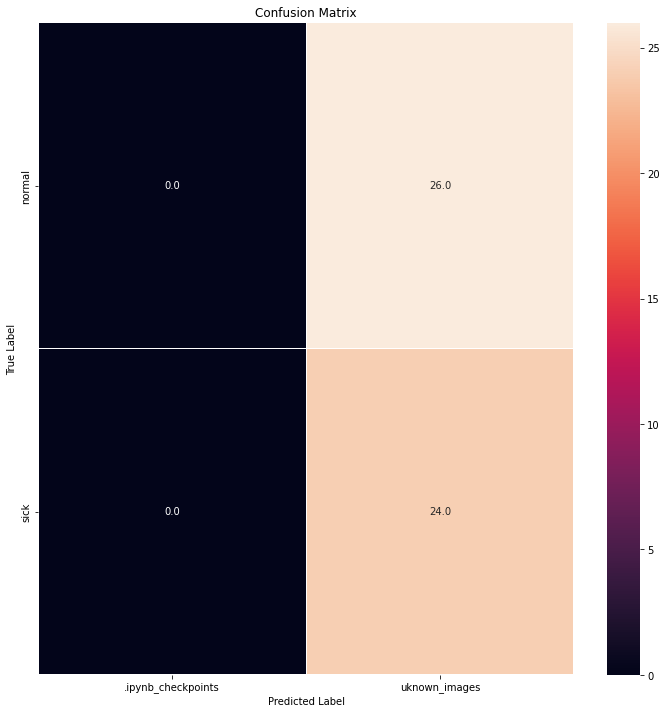

In [27]:
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(image_class)
plt.title("Confusion Matrix")
plt.show()

In [28]:
report2 = classification_report(test_ds.classes, y_pred, target_names=image_class, output_dict=True)
df2 = pd.DataFrame(report2).transpose()
df2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
normal,0.00,0.00,0.000000,0.00
sick,1.00,0.48,0.648649,50.00
accuracy,0.48,0.48,0.480000,0.48
macro avg,0.50,0.24,0.324324,50.00
weighted avg,1.00,0.48,0.648649,50.00


In [29]:
df2.to_csv(r'/content/drive/MyDrive/Colab Notebooks/deeplearning/dataset2.txt', header=True, index=True, sep = '\t', mode='a')